In [1]:
import xarray as xr
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf

In [2]:
#
# input information
#
input_dir = '/glade/work/hardt/ds612'
#
latlon_filename = 'model2_latlon_coord.nc'
refl_filename = 'model2_5minuteAfterHour_3D_refl_shuffled.nc'
W_filename = 'model2_3D_W_shuffled.nc'

latlonFile = os.path.join(input_dir, latlon_filename)
reflFile = os.path.join(input_dir, refl_filename)
WFile = os.path.join(input_dir, W_filename)

In [3]:
#
# Parameters
#
refl_height = 0         # 0-10
composite_refl = False
#
W_height = 4            # 0-51
composite_W = True
#
label_feature_thresh = 0.001
apply_thresh = False
#
# if false the threshold is on the
# refl_height instead of a composite
#
thresh_on_refl_comp = False
#
image_number = 1510

In [4]:
#
# set up lat lon arrays
#
latlon_ds = xr.open_mfdataset(latlonFile, combine='by_coords')
lat = latlon_ds.XLAT[0,:,:].values
lon = latlon_ds.XLONG[0,:,:].values

In [5]:
#
# read in the reflectivity data
#
refl_ds = xr.open_mfdataset(reflFile, combine='by_coords')
ref_t = refl_ds.XTIME[image_number].values
print(refl_ds)
print(ref_t)
#
refl = refl_ds.REFL_10CM[image_number,refl_height,:,:].values
print(refl.shape)
refl_comp = refl_ds.REFL_10CM[image_number,:,:,:].values.max(axis=0)
#
print(refl.shape)

<xarray.Dataset>
Dimensions:    (dim_0: 4896, dim_1: 10, dim_2: 256, dim_3: 256)
Dimensions without coordinates: dim_0, dim_1, dim_2, dim_3
Data variables:
    REFL_10CM  (dim_0, dim_1, dim_2, dim_3) float32 dask.array<chunksize=(4896, 10, 256, 256), meta=np.ndarray>
    XTIME      (dim_0) datetime64[ns] dask.array<chunksize=(4896,), meta=np.ndarray>
2013-05-24T06:05:00.000000000
(256, 256)
(256, 256)


In [6]:
#
# read in the W data
#
W_ds = xr.open_mfdataset(WFile, combine='by_coords')
W_t = W_ds.XTIME[image_number].values
print(W_ds)
print(W_t)
#
if composite_W:
    W = W_ds.W[image_number,:,:,:].values.max(axis=0)
else:
    W = W_ds.W[image_number,W_height,:,:].values
    
if apply_thresh:
    if thresh_on_refl_comp:
        W[refl_comp<label_feature_thresh] = -99.0
    else:
        W[refl<label_feature_thresh] = -99.0
#
print(W.shape)

<xarray.Dataset>
Dimensions:  (dim_0: 4896, dim_1: 51, dim_2: 256, dim_3: 256)
Dimensions without coordinates: dim_0, dim_1, dim_2, dim_3
Data variables:
    W        (dim_0, dim_1, dim_2, dim_3) float32 dask.array<chunksize=(4896, 51, 256, 256), meta=np.ndarray>
    XTIME    (dim_0) datetime64[ns] dask.array<chunksize=(4896,), meta=np.ndarray>
2013-05-24T06:00:00.000000000
(256, 256)


In [7]:
#
# get the data time string
#
year = str(W_t)[0:4]
month = str(W_t)[5:7]
day = str(W_t)[8:10]
hour = str(W_t)[11:13]
minute = str(W_t)[14:16]
full_datetime_string = year + month + day + " " + hour + ':' + minute + ' ' + 'UTC'
print(full_datetime_string)

20130524 06:00 UTC


0.9161169 1.7466238 1.4072685110569283


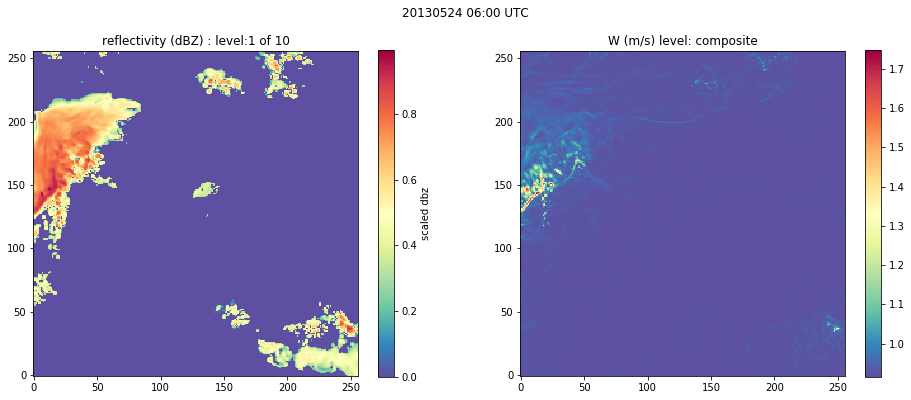

In [8]:
#
# images without the geo-refrencing
#
cmap = plt.cm.Spectral_r


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6)) 
fig.suptitle(full_datetime_string)
#
if composite_refl:
    p_ref = np.percentile(refl_comp[:,:], 99.9)
    max_ref = np.amax(refl_comp[:,:])
    ref_p = ax1.imshow(refl_comp, cmap=cmap,origin='lower')
    ax1.set_title("reflectivity (dBZ) : level: composite")
else:
    p_ref = np.percentile(refl[:,:], 99.9)
    max_ref = np.amax(refl[:,:])
    ref_p = ax1.imshow(refl, cmap=cmap,origin='lower')
    ax1.set_title("reflectivity (dBZ) : level:" + str(refl_height+1) + " of 10")
#
#ref_p.set_clim(vmin=0, vmax=1.0)
fig.colorbar(ref_p, ax=ax1, orientation='vertical', label='scaled dbz')

min_W = np.amin(W[:,:])
max_W = np.amax(W[:,:])
p_W = np.percentile(W[:,:], 99.9)

W_p = ax2.imshow(W, cmap=cmap,origin='lower')
#
if composite_W:
    ax2.set_title("W (m/s) level: composite" )
else:
    ax2.set_title("W (m/s) level:" + str(W_height+1) + " of 51" )
#
#maxW.set_clim(vmin=0.0, vmax=max_W)
#W_p.set_clim(vmin=0.0,vmax=p_W)
#W_p.set_clim(vmin=0.9,vmax=1.0)
#W_p.set_clim()
fig.colorbar(W_p, ax=ax2)

print(min_W, max_W, p_W)

In [9]:
#
# changes to the colormap
#
from matplotlib.colors import ListedColormap

cmap = plt.cm.get_cmap('Spectral_r', 256)
newcolors = cmap(np.linspace(0, 1, 256))
pink = np.array([248/256, 24/256, 148/256, 1])
lt_gray = np.array([240/256, 240/256, 240/256, 1])
newcolors[:1, :] = lt_gray
mycmap = ListedColormap(newcolors)
#print(newcmap(range(12)))
#print('newcmap(np.linspace(0, 1, 12))', newcmp(np.linspace(0, 1, 12)))

In [ ]:
#
# images with geo-referencing
#

def plot_background(ax):
    #ax.set_extent([235., 290., 20., 55.])
    #ax.set_extent([-102, -85, 30, 45])
    ax.add_feature(cf.COASTLINE.with_scale('50m'), linewidth=0.5)
    ax.add_feature(cf.STATES, linewidth=0.5)
    ax.add_feature(cf.BORDERS, linewidth=0.5)
    ax.add_feature(cf.OCEAN)
    ax.add_feature(cf.LAKES, edgecolor='black')
    ax.add_feature(cf.LAND, facecolor='white', edgecolor='none')
    #ax.add_feature(cf.LAND, facecolor='wheat', edgecolor='none')

    return ax

#
# set up plot
#
crs = ccrs.LambertConformal(central_longitude=-100.0, central_latitude=45.0)
#
#cmap = plt.cm.Spectral_r
cmap=mycmap
#
fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(23, 10), subplot_kw={'projection': crs})
fig.suptitle(full_datetime_string + '\nimage #' + str(image_number))
#
axlist = axarr.flatten()
for ax in axlist:
    plot_background(ax)
#
# Reflectivity
#
if composite_refl:
    cf1 = axlist[0].pcolormesh(lon, lat, refl_comp, cmap=cmap, transform = ccrs.PlateCarree())
    axlist[0].set_title('Reflectivity Level: composite\nfile: ' + refl_filename, fontsize=16)
else:
    cf1 = axlist[0].pcolormesh(lon, lat, refl, cmap=cmap, transform = ccrs.PlateCarree())
    axlist[0].set_title('Reflectivity Level: ' + str(refl_height+1) + ' of 10\nfile: ' + refl_filename, fontsize=16)
#
cb1 = fig.colorbar(cf1, ax=axlist[0], orientation='vertical', shrink=0.86, pad=0.05)#, cmap=cmap)#, norm=norm, ticks=bounds)
cb1.mappable.set_clim(0.001,1)
cb1.set_label('scaled dBZ', size='x-large')
#
# Plotting W
#
cf2 = axlist[1].pcolormesh(lon, lat, W, cmap=cmap, transform = ccrs.PlateCarree())
if composite_W:
    axlist[1].set_title('W Level: composite\nfile: ' + W_filename, fontsize=16)
else:
    axlist[1].set_title('W Level: ' + str(W_height+1) + ' of 51\nfile: ' + W_filename, fontsize=16)
#
cb2 = fig.colorbar(cf2, ax=axlist[1], orientation='vertical', shrink=0.86, pad=0.05, 
                   cmap=cmap)#, norm=norm, ticks=bounds, extend='both', boundaries=[-10] + bounds + [10], spacing='uniform', extendfrac='auto')
cb2.mappable.set_clim(0.9,0.99)
cb2.set_label('scaled W', size='x-large')
#
# build the output filename
#
if composite_refl and not composite_W:
    output_filename = refl_filename + '_comp' + '-' + W_filename + '_' + str(W_height)
elif not composite_refl and composite_W:
    output_filename = refl_filename + '_' + str(refl_height) + '-' + W_filename + '_comp'
elif composite_refl and composite_W:
    output_filename = refl_filename + '_comp' + '-' + W_filename + '_comp'
else:
    output_filename = refl_filename + '_' + str(refl_height) + '_' + str(refl_height) + '-' + W_filename + '_' + str(W_height)
#    
if apply_thresh:
    output_filename = output_filename + '_thresh'
#    
output_filename = output_filename + '-image' + str(image_number) + '.png'
#
# Write output file
#
print('Writing image to output file', output_filename)
print()
plt.savefig(output_filename)

Writing image to output file model2_5minuteAfterHour_3D_refl_shuffled.nc_0-model2_3D_W_shuffled.nc_comp-image1510.png

